In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Load Data

In [2]:
PATH_data = "data"
PATH_results = "logs"

batch_size = 64
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr22_overlap_train_methyl_array.pkl").returnTensor_()

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Read in AE model

In [3]:
name = f"optLatSize/latSize_25" #f"optLatSize/latSize_7" 
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# Train and predict with RFRegressor
(from latent space)

In [4]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)    

## Remove samples with NA in target
# Train
y_train = train_tensor[1].detach().numpy()
mask_train = ~np.isnan(y_train)
latSpace_train = latSpace_train[mask_train]
y_train = y_train[mask_train]
# Test
y_test = test_dataset["pheno"]["Age"].values
mask_test = ~np.isnan(y_test)
latSpace_test = latSpace_test[mask_test]
y_test = y_test[mask_test]

# Train RFregression model
regr = RandomForestRegressor(random_state=0)
regr.fit(latSpace_train, y_train)
featureImportances = regr.feature_importances_

# Score on Test set
y_pred = regr.predict(latSpace_test)
r2 = regr.score(latSpace_test, y_test)

# save model
outPath = f"logs/{name}/regression/"
os.makedirs(outPath, exist_ok=True)
pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

Text(0.5, 0, 'Feature')

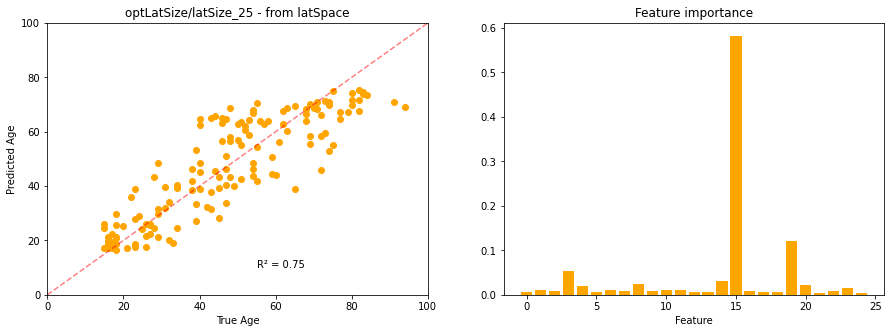

In [5]:
fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax.scatter(y_test, y_pred, color="orange")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_title(f"{name} - from latSpace")
ax.set_xlabel("True Age")
ax.set_ylabel("Predicted Age")

ax2.bar(x=range(len(featureImportances)), height=featureImportances, color="orange")
ax2.set_title("Feature importance")
ax2.set_xlabel("Feature")

# Train and predict from input CpG data

In [21]:
## Remove samples with NA in target
# Train
y_train = train_tensor[1].detach().numpy()
mask_train = ~np.isnan(y_train)
X_train = train_tensor[0].detach().numpy()[mask_train]
y_train = y_train[mask_train]
# Test
y_test = test_dataset["pheno"]["Age"].values
mask_test = ~np.isnan(y_test)
X_test = test_dataset["beta"][mask_test].values
y_test = y_test[mask_test]

# Train RFregression model
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

# Score on Test set
y_pred = regr.predict(X_test)
r2 = regr.score(X_test, y_test)

# # save model
# outPath = f"logs/{name}/regression/"
# os.makedirs(outPath, exist_ok=True)
# pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

Text(0, 0.5, 'Predicted Age')

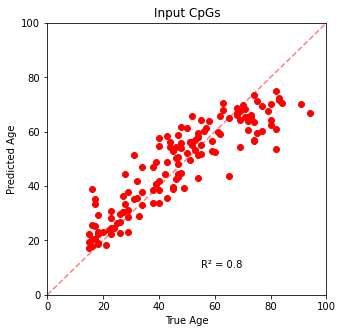

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred, color="red")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_title(f"Input CpGs")
ax.set_xlabel("True Age")
ax.set_ylabel("Predicted Age")

# Predict only wiht best latent feature

In [9]:
featureImportances == featureImportances.max()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False])

In [19]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)    

## Remove samples with NA in target
# Train
y_train = train_tensor[1].detach().numpy()
mask_train = ~np.isnan(y_train)
latSpace_train = latSpace_train[mask_train]
y_train = y_train[mask_train]
# Test
y_test = test_dataset["pheno"]["Age"].values
mask_test = ~np.isnan(y_test)
latSpace_test = latSpace_test[mask_test]
y_test = y_test[mask_test]


latSpace_train = latSpace_train[:,15].reshape(-1, 1)
latSpace_test = latSpace_test[:,15].reshape(-1, 1)
 
# Train RFregression model  --- ONLY ON BEST FEATURE
regr = RandomForestRegressor(random_state=0)
regr.fit(latSpace_train, y_train)
featureImportances = regr.feature_importances_

# Score on Test set
y_pred = regr.predict(latSpace_test)
r2 = regr.score(latSpace_test, y_test)

Text(0, 0.5, 'Predicted Age')

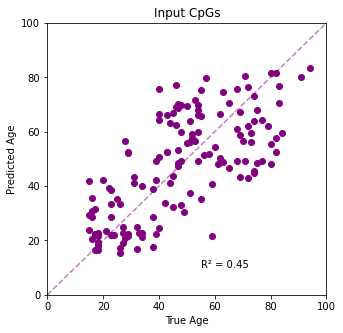

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred, color="purple")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="purple", linestyle="dashed", alpha=0.5)
ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_title(f"Input CpGs")
ax.set_xlabel("True Age")
ax.set_ylabel("Predicted Age")

# STILL TRY THIS

In [22]:
# ## Remove samples with NA in target
# # Train
# y_train = train_tensor[1].detach().numpy()
# mask_train = ~np.isnan(y_train)
# X_train = train_tensor[0].detach().numpy()[mask_train]
# y_train = y_train[mask_train]
# # Test
# y_test = test_dataset["pheno"]["Age"].values
# mask_test = ~np.isnan(y_test)
# X_test = test_dataset["beta"][mask_test].values
# y_test = y_test[mask_test]

# # Train RFregression model
# regr = RandomForestRegressor(random_state=0)
# regr.fit(X_train, y_train)

# # Score on Test set
# y_pred = regr.predict(X_test)
# r2 = regr.score(X_test, y_test)

# # # save model
# # outPath = f"logs/{name}/regression/"
# # os.makedirs(outPath, exist_ok=True)
# # pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

KeyboardInterrupt: 

In [ ]:
X_train

NameError: name 'X_train' is not defined